## Data Loading

In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # layers of keras

In [44]:
df_tweets = pd.read_csv("/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv")
df_tweets[:10]

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",not_cyberbullying
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,not_cyberbullying
7,Karma. I hope it bites Kat on the butt. She is...,not_cyberbullying
8,@stockputout everything but mostly my priest,not_cyberbullying
9,Rebecca Black Drops Out of School Due to Bully...,not_cyberbullying


In [45]:
df_tweets.groupby(by="cyberbullying_type").count()

,tweet_text
cyberbullying_type,
age,7992
ethnicity,7961
gender,7973
not_cyberbullying,7945
other_cyberbullying,7823
religion,7998


## Data Cleaning
### Checking Missing Values

In [46]:
def check_missing_values(col):
    counter = 0
    for element in col:
        if element == True:
            counter += 1
    return counter

In [47]:
df_tweets.isnull().apply(lambda x: check_missing_values(x))

tweet_text            0
cyberbullying_type    0
dtype: int64

### Checking Duplicates

In [48]:
def check_duplicated_values(x):
    return x.duplicated().sum()

In [49]:
df_tweets.apply(lambda x: check_duplicated_values(x))

tweet_text             1675
cyberbullying_type    47686
dtype: int64

In [50]:
df_tweets.loc[:,["tweet_text"]].duplicated().sum()

1675

In [51]:
df_tweets = df_tweets.drop_duplicates(subset=['tweet_text'])

In [52]:
df_tweets.apply(lambda x: check_duplicated_values(x))

tweet_text                0
cyberbullying_type    46011
dtype: int64

In [53]:
df_tweets.groupby(by="cyberbullying_type").count()

,tweet_text
cyberbullying_type,
age,7992
ethnicity,7952
gender,7898
not_cyberbullying,7937
other_cyberbullying,6243
religion,7995


## Data Transformation
### Balancing the Dataset

In [54]:
df_tweets = df_tweets.groupby(by="cyberbullying_type").sample(n=1000, random_state=1)
print("Length: "+ str(len(df_tweets)))
df_tweets[:5]

Length: 6000


,tweet_text,cyberbullying_type
34044,She looks so beautiful and she’s has a very ki...,age
38234,My old high school bully just tried to menace ...,age
36306,From my experience PE teachers are bullies. I ...,age
36793,ew why is gun/poop girl trending literally go ...,age
37263,Lara Spencer is so unprofessional. She bullied...,age


In [55]:
df_tweets.groupby(by="cyberbullying_type").count()

,tweet_text
cyberbullying_type,
age,1000
ethnicity,1000
gender,1000
not_cyberbullying,1000
other_cyberbullying,1000
religion,1000


## Data Preprocessing

### One-Hot Encoding and Creation of Sets

In [56]:
cyberbullying_types = set(df_tweets['cyberbullying_type'].unique())
cyberbullying_types

{'age',
 'ethnicity',
 'gender',
 'not_cyberbullying',
 'other_cyberbullying',
 'religion'}

In [57]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from numpy import argmax

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
df_x_tv, df_x_test, df_y_tv, df_y_test = train_test_split(df_tweets['tweet_text'], df_tweets['cyberbullying_type'], test_size=0.20,random_state=42)

In [60]:
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df_y_tv)
print("integer_encoded")
print(integer_encoded)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("onehot_encoded")
print(onehot_encoded)
print("length: " + str(len(onehot_encoded)))

# invert first example
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[1, :])])
inverted

integer_encoded
[3 5 1 ... 5 5 0]
onehot_encoded
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]]
length: 4800


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array(['religion'], dtype=object)

In [61]:
def label_decode(labels):
    decoding = np.argmax(labels, axis=1)
    return label_encoder.inverse_transform(decoding)

label_decode(onehot_encoded)

array(['not_cyberbullying', 'religion', 'ethnicity', ..., 'religion',
       'religion', 'age'], dtype=object)

In [62]:
df_x_train, df_x_valid, df_y_train, df_y_valid = train_test_split(df_x_tv, onehot_encoded, test_size=0.30,random_state=42)

In [63]:
df_x_train[:1]

23126    they're fundamentalists who are guilty of war ...
Name: tweet_text, dtype: object

## Modelling - TextVectorization Layer

In [64]:
TextVectorization_layer = tf.keras.layers.TextVectorization(max_tokens=3000,output_mode='tf_idf',pad_to_max_tokens=True)
#TextVectorization_layer = tf.keras.layers.TextVectorization()
TextVectorization_layer.adapt(df_tweets.tweet_text)

In [65]:
# getting our tokens and their size
vocab_tokens = TextVectorization_layer.get_vocabulary()
vocab_size = len(TextVectorization_layer.get_vocabulary())
vocab_size

3000

## Modelling - Embedding Layer and Tranfer Learning
Using SpaCy pre-trained embedding vectors for transfer learning in a Keras deep learning model.

In [66]:
from keras.initializers import Constant
import spacy
nlp = spacy.load('en_core_web_sm')

In [67]:
# Creating an embedding matrix
embedding_dim = len(nlp('gecko').vector)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for i, word in enumerate(vocab_tokens):
    if word != '':
        embedding_matrix[i] = nlp(str(word)).vector

In [68]:
# Loading the embedding matrix as the weights matrix for the embedding layer
# Seting trainable to False to avoid training the vectors again
Embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, embeddings_initializer=Constant(embedding_matrix), trainable=False)

## Modelling - The rest of the model

In [69]:
regularizer = tf.keras.regularizers.l1_l2(0, 0.001)
classes_len = 6

In [73]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(1,), dtype=tf.string))
model.add(TextVectorization_layer)
model.add(Embedding_layer)
model.add(tf.keras.layers.Flatten())
# when is a changing sequence I suggest using this other layer instead of flatten. 
# In this example I used a padding of zeros in the textvectorization layer making better to use flatten layer
#model.add(tf.keras.layers.GlobalMaxPool1D()) 
model.add(tf.keras.layers.Dense(500, kernel_regularizer=regularizer, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(200, kernel_regularizer=regularizer, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(200, kernel_regularizer=regularizer, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(50, kernel_regularizer=regularizer, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(classes_len, kernel_regularizer=regularizer))
model.add(tf.keras.layers.Softmax())

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 3000)             1         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 3000, 96)          288000    
                                                                 
 flatten_4 (Flatten)         (None, 288000)            0         
                                                                 
 dense_20 (Dense)            (None, 500)               144000500 
                                                                 
 dense_21 (Dense)            (None, 200)               100200    
                                                                 
 dense_22 (Dense)            (None, 200)               40200     
                                                      

In [74]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=['accuracy'])

epoch = 10
batch = 30

In [75]:
history = model.fit(df_x_train, df_y_train, epochs=epoch, batch_size=batch, validation_data=(df_x_valid,df_y_valid))

Epoch 1/10
112/112 [==============================] - 216s 2s/step - loss: 33.9699 - accuracy: 0.1655 - val_loss: 6.7599 - val_accuracy: 0.1639
Epoch 2/10
112/112 [==============================] - 214s 2s/step - loss: 5.2189 - accuracy: 0.2342 - val_loss: 5.0976 - val_accuracy: 0.1757
Epoch 3/10
112/112 [==============================] - 214s 2s/step - loss: 3.8381 - accuracy: 0.2881 - val_loss: 2.4923 - val_accuracy: 0.4472
Epoch 4/10
112/112 [==============================] - 214s 2s/step - loss: 2.3031 - accuracy: 0.4500 - val_loss: 2.2714 - val_accuracy: 0.4472
Epoch 5/10
112/112 [==============================] - 214s 2s/step - loss: 2.1779 - accuracy: 0.4479 - val_loss: 2.0703 - val_accuracy: 0.5299
Epoch 6/10
112/112 [==============================] - 214s 2s/step - loss: 2.1071 - accuracy: 0.4625 - val_loss: 1.7879 - val_accuracy: 0.5771
Epoch 7/10
112/112 [==============================] - 214s 2s/step - loss: 2.1082 - accuracy: 0.4339 - val_loss: 1.9367 - val_accuracy: 0.472

### Visualization Generalization Results

In [76]:
import matplotlib.pyplot as plt

def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric])
        ax[idx].legend([metric, 'val_' + metric])

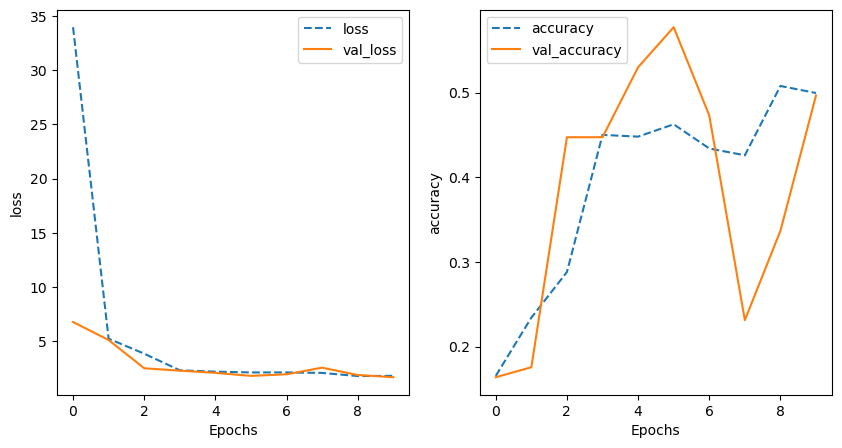

In [77]:
training_plot(['loss', 'accuracy'], history)

### Predictions

In [79]:
df_y_test_pred = model.predict(df_x_test)

38/38 [==============================] - 6s 169ms/step


In [80]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Funtion for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    classes.sort()
    tick_marks = np.arange(len(classes))    
    plt.figure(figsize=(4, 4),dpi=115)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [81]:
pred_result = label_decode(df_y_test_pred)

In [82]:
pred_result

array(['gender', 'gender', 'age', ..., 'gender', 'religion', 'ethnicity'],
      dtype=object)

In [83]:
df_y_test

40508            ethnicity
7105     not_cyberbullying
38429                  age
15111               gender
15993             religion
               ...        
10592               gender
45347            ethnicity
8129                gender
18323             religion
44287            ethnicity
Name: cyberbullying_type, Length: 1200, dtype: object

In [84]:
pred_result = label_decode(df_y_test_pred)
true_result = df_y_test
print(classification_report(y_true=true_result, y_pred=pred_result))

                     precision    recall  f1-score   support

                age       0.92      0.98      0.95       215
          ethnicity       1.00      0.38      0.55       222
             gender       0.23      0.99      0.37       176
  not_cyberbullying       0.00      0.00      0.00       204
other_cyberbullying       0.00      0.00      0.00       189
           religion       0.91      0.58      0.71       194

           accuracy                           0.48      1200
          macro avg       0.51      0.49      0.43      1200
       weighted avg       0.53      0.48      0.44      1200



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix, without normalization


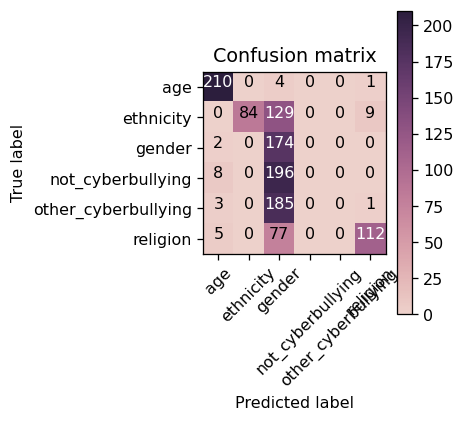

In [85]:
# plot confusion matrix
labels = ['age', 'ethnicity' ,'gender', 'not_cyberbullying' ,'other_cyberbullying','religion']
cm = confusion_matrix(y_true=true_result, y_pred=pred_result) 
plot_confusion_matrix(cm, classes=labels, title='Confusion matrix')

## Final Thoughts
Well the example didnt go well. Nothingless, it is a good example of underfitting. Even after eliminating dropouts in the DNN to avoid repetition in validation accuracy and loss. Furthermore, the tranfer learning was in a way succesful even if the generalization of the model is bad. One solution can be using a different combination of parameters in the textvectorization layer.

However, in whatever case, a real challenge in the model is separate: not cyberbullying vs other cyberbullying. Because the category other_cyberbullying doesn't belong to some specific category. Its scope is bigger than the other categories, making it difficult to difference its key patterns.